In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

from IPython.display import clear_output

# Data

In [0]:
# get the data, a.json are "good" posture, b.json are "bad" postures

# !curl -F "file=@something.ext" https://file.io
!curl -o a.json https://raw.githubusercontent.com/aunz/ds-upright/master/data/a.json
!curl -o b.json https://raw.githubusercontent.com/aunz/ds-upright/master/data/b.json

!ls -lah

clear_output()

In [0]:
# func to load json, extract x, y, concatenate them, turn into np.array, normalise /480
def tmp(f):
    tmp = json.load(f)
    tmp_x = np.array([[j['position']['x'] for j in i['keypoints']] for i in tmp])
    tmp_x = tmp_x.clip(0, 480)
    tmp_x2 = 480 - tmp_x # create mirror
    tmp_y = np.array([[j['position']['y'] for j in i['keypoints']] for i in tmp])
    tmp_y = tmp_y.clip(0, 270)
    tmp_name1 = np.array([i['name'] for i in tmp]) # a1 001, a1 002 etc
    tmp_name2 = np.array([i['name'] + ' m ' for i in tmp]) # mirror
    tmp1 = np.concatenate((tmp_x, tmp_y), axis=1) / 480
    tmp2 = np.concatenate((tmp_x2, tmp_y), axis=1) / 480
    return np.concatenate((tmp1, tmp2)), np.concatenate((tmp_name1, tmp_name2))
    

with open('a.json', 'r') as f: a, a_name = tmp(f)
with open('b.json', 'r') as f: b, b_name = tmp(f)
    
# combining a, b to a dataset

X = np.concatenate((a, b))
y = np.append(np.zeros(len(a)), np.ones(len(b))) # 0: a, 1: b

ab_name = np.concatenate((a_name, b_name)) 

print(a.shape, b.shape, X.shape, y.shape, ab_name.shape)

del tmp, a, b, a_name, b_name

(20950, 34) (20914, 34) (41864, 34) (41864,) (41864,)


In [0]:
# split into 60% train, 20% val, 20% test
np.random.seed(0)

tmp = np.random.permutation(len(X))
tmp_train = tmp[:round(len(tmp) * 0.6)]
tmp_val = tmp[round(len(tmp) * 0.6):round(len(tmp) * 0.8)]
tmp_test = tmp[round(len(tmp) * 0.8):]

X_train, y_train = X[tmp_train], y[tmp_train]
X_val, y_val = X[tmp_val], y[tmp_val]
X_test, y_test = X[tmp_test], y[tmp_test]

ab_name_train = ab_name[tmp_train]
ab_name_val = ab_name[tmp_val]
ab_name_test = ab_name[tmp_test]

print('Train', X_train.shape, y_train.shape, y_train.mean())
print('Val', X_val.shape, y_val.shape, y_val.mean())
print('Test', X_test.shape, y_test.shape, y_test.mean())

del tmp, tmp_train, tmp_val, tmp_test

Train (25118, 34) (25118,) 0.5019507922605303
Val (8373, 34) (8373,) 0.4951630240057327
Test (8373, 34) (8373,) 0.4968350650901708


# Training

## Regression

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='auto', max_iter=1000).fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_val, y_val))
print(model.score(X_test, y_test))

# confusion_matrix(y_val, model.predict(X_val))

print(classification_report(y_val, model.predict(X_val)))

# print('Intercept', f'''model.intercept_''', '\nCoef', model.coef_)

print(f'''Intercept {model.intercept_[0]:.3f}
Coefs: {', '.join([f"{x:.3f}" for x in model.coef_[0]])}''')

with open('intercept_coefs.json', 'w') as f: json.dump({ 'int': model.intercept_[0], 'coefs': model.coef_[0].tolist()}, f)

0.9371765267935345
0.9390899319240416
0.9361041442732593
              precision    recall  f1-score   support

         0.0       0.91      0.97      0.94      4227
         1.0       0.97      0.90      0.94      4146

   micro avg       0.94      0.94      0.94      8373
   macro avg       0.94      0.94      0.94      8373
weighted avg       0.94      0.94      0.94      8373

Intercept 3.007
Coefs: 0.329, 1.281, -0.091, 0.327, 0.896, -2.538, -0.116, -0.273, -0.354, -0.164, 0.138, 1.089, 0.358, 0.454, -0.002, -0.317, -0.234, 24.394, 20.167, 19.191, 22.313, 8.383, -8.004, -6.711, -8.682, -3.726, 2.427, 9.118, -18.770, -17.280, -9.017, -11.434, 2.586, 1.245


In [0]:
# can use these coef_ and intercept_ for javascript, check a few samples manually

def predict(x):
    tmp = (x * model.coef_).sum() + model.intercept_
    tmp = 1 / (1 + np.exp(-tmp))
    return tmp

for i in range(0, 20):
    print(ab_name_val[i], predict(X_val[i]), model.predict_proba(X_val)[i][1])

a7 020 [0.08539954] 0.0853995412193786
a1 540 [0.22460002] 0.22460002289268655
b4 813 m  [0.02802288] 0.028022881694207153
b10 816 [0.98933965] 0.989339648353709
a6 431 m  [0.39762508] 0.3976250772342188
b10 083 m  [0.85136408] 0.8513640820851378
b9 0042 [0.84968416] 0.8496841608975633
a5 836 [0.29135142] 0.2913514219928503
b6 138 m  [0.96556088] 0.9655608760193223
a2 360 [0.12825749] 0.12825748620843244
a4 372 m  [0.27582101] 0.2758210104866193
a4 041 [0.17465062] 0.17465061636159862
b3 094 m  [0.99176588] 0.9917658777877499
a6 246 [0.22968684] 0.22968683967131415
b11 0041 m  [0.52913162] 0.5291316189009646
b8 084 [0.92240829] 0.9224082900787459
a5 377 m  [0.1957198] 0.1957198043772266
a2 295 [0.13467896] 0.13467896059249196
a7 075 [0.08684284] 0.08684284046133575
b8 896 m  [0.97357451] 0.9735745137178458


## KNN

In [0]:
%%time

from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

print(model.score(X_train, y_train))
print(model.score(X_val, y_val))
print(model.score(X_test, y_test))

# confusion_matrix(y_val, model.predict(X_val))

print(classification_report(y_val, model.predict(X_val)))

0.9991639461740585
0.9989251164457184
0.9990445479517497
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4227
         1.0       1.00      1.00      1.00      4146

   micro avg       1.00      1.00      1.00      8373
   macro avg       1.00      1.00      1.00      8373
weighted avg       1.00      1.00      1.00      8373

CPU times: user 8.73 s, sys: 23.3 ms, total: 8.75 s
Wall time: 9.43 s


## Basic neural network

In [0]:
!pip install tensorflowjs # for exporting model to js

from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, SeparableConv2D, MaxPooling2D, AveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Flatten, Dropout, InputLayer
from keras.optimizers import Adam, Adamax, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

clear_output()

from tensorflowjs.converters import save_keras_model

In [0]:
def train(make_model, n = 5, optimizer = lambda: 'rmsprop', callbacks = lambda: [EarlyStopping(patience=5, verbose=1)], verbose=0):
    # given a model, train it for n times and plot the associated metrics
    # make_model, optimizer and callbacks should be provided as a function as each time the functions are called, brand new instances are created in the for loop below. Use this because can't use deepcopy

    models = [] # to hold the model weights
    hists = [] # contains all the history
    
    make_model(None).summary()
    
    plt.figure(figsize=(4 * (n + 2), 8)) # the figure

    for i in range(n):
        model = make_model(i)
        model.compile(loss='binary_crossentropy', optimizer=optimizer(), metrics=['accuracy'])
        hist = model.fit(X_train, y_train, batch_size=4096, epochs=200, validation_data=(X_val, y_val), callbacks=callbacks(), verbose=verbose)        
        hists.append(hist)
        
        models.append(model) # store the model
#         model.set_weights(initial_weights) # restore to the original weights

        r = range(2, len(hist.history['acc']) + 1) # starting from epoch 2, ignore the first epoch
        plt.subplot(2, n + 1, i + 2) # plot the loss history, starting with subplot 3
        plt.plot(r, hist.history['loss'][1:], '.-', label='Train loss') # ignore the first epoch
        plt.plot(r, hist.history['val_loss'][1:], '.-', label='Val loss')
        plt.legend()
        
        plt.subplot(2, n + 1, i + 2 + n + 1) # plot the acc history, starting with subplot 3
        plt.plot(r, hist.history['acc'][1:], '.-', label='Train acc')
        plt.plot(r, hist.history['val_acc'][1:], '.-', label='Val acc')
        plt.legend()

    
    plt.subplot(2, n + 1, 1) # plot the loss summary at the first subplot
    metrics = ['loss'] * n + ['val_loss'] * n 
    values = np.concatenate([
        [i.history['loss'][-1] for i in hists],
        [i.history['val_loss'][-1] for i in hists],
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Loss')
    values = values.reshape(2, -1)
    print('Loss', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))
    
    plt.subplot(2, n + 1, n + 2) # plot the acc summary at the second subplot
    metrics = ['acc'] * n + ['val_acc'] * n
    values = np.concatenate([
        [i.history['acc'][-1] for i in hists],
        [i.history['val_acc'][-1] for i in hists]
    ])
    plt.plot(metrics, values, '.')
    plt.ylabel('Accuracy')
    values = values.reshape(2, -1)
    print('\nAcc', *values)
    print('Mean', values.mean(1), 'Std', values.std(1))

    plt.tight_layout()
    
    return models, hists


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_78 (Dense)             (None, 32)                1120      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 33        
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________
Train on 25118 samples, validate on 8373 samples
Epoch 1/200
25118/25118 [==============================] - 2s 74us/step - loss: 0.7113 - acc: 0.5071 - val_loss: 0.6976 - val_acc: 0.5674
Epoch 2/200
25118/25118 [==============================] - 0s 2us/step - loss: 0.6944 - acc: 0.6415 - val_loss: 0.6935 - val_acc: 0.6538
Epoch 3/200
25118/25118 [==============================] - 0s 2us/step - loss: 0.6917 - acc: 0.6786 - val_loss: 0.6901 - val_acc: 0.4335
Epoch 4/200
25118/25118 [==============================] - 0s 2us/step - lo

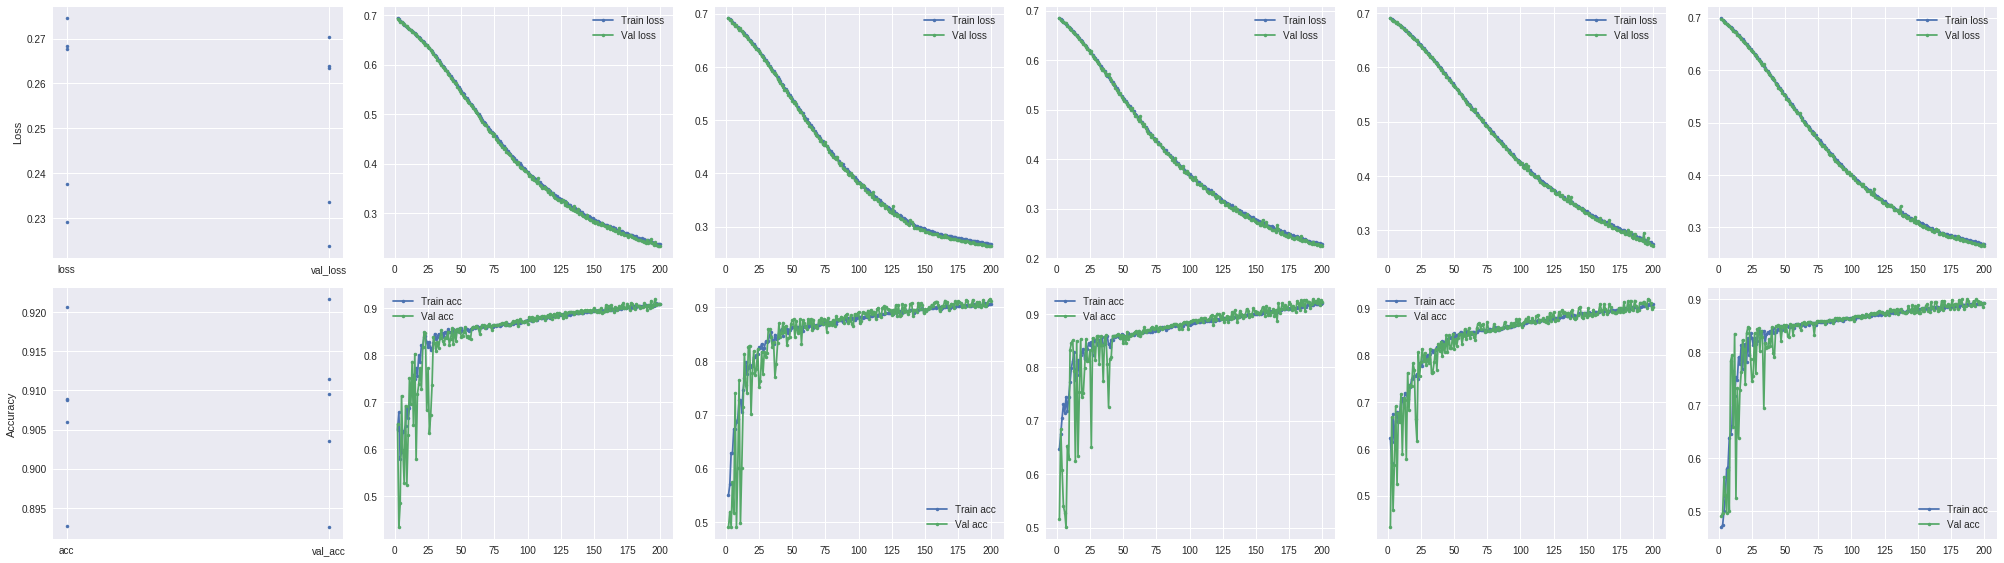

In [0]:
%%time

# just 1 hidden layer, 1153 params, ~0.91 accu

callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]

models, hists = train(lambda x: Sequential([
    Dense(32, input_shape=(X.shape[1],), activation='relu'),
    Dense(1, activation='sigmoid')
]), callbacks=callbacks, verbose=1)

[save_keras_model(model, './model_NN_1_' + str(i)) for i, model in enumerate(models)];
!zip -r -qq models_NN_1.zip model_NN_1_0 model_NN_1_1 model_NN_1_2 model_NN_1_3 model_NN_1_4


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 32)                1120      
_________________________________________________________________
dense_50 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_51 (Dense)             (None, 1)                 33        
Total params: 2,209
Trainable params: 2,209
Non-trainable params: 0
_________________________________________________________________
Train on 25118 samples, validate on 8373 samples
Epoch 1/200
25118/25118 [==============================] - 1s 37us/step - loss: 0.6965 - acc: 0.5148 - val_loss: 0.6861 - val_acc: 0.6393
Epoch 2/200
25118/25118 [==============================] - 0s 2us/step - loss: 0.6857

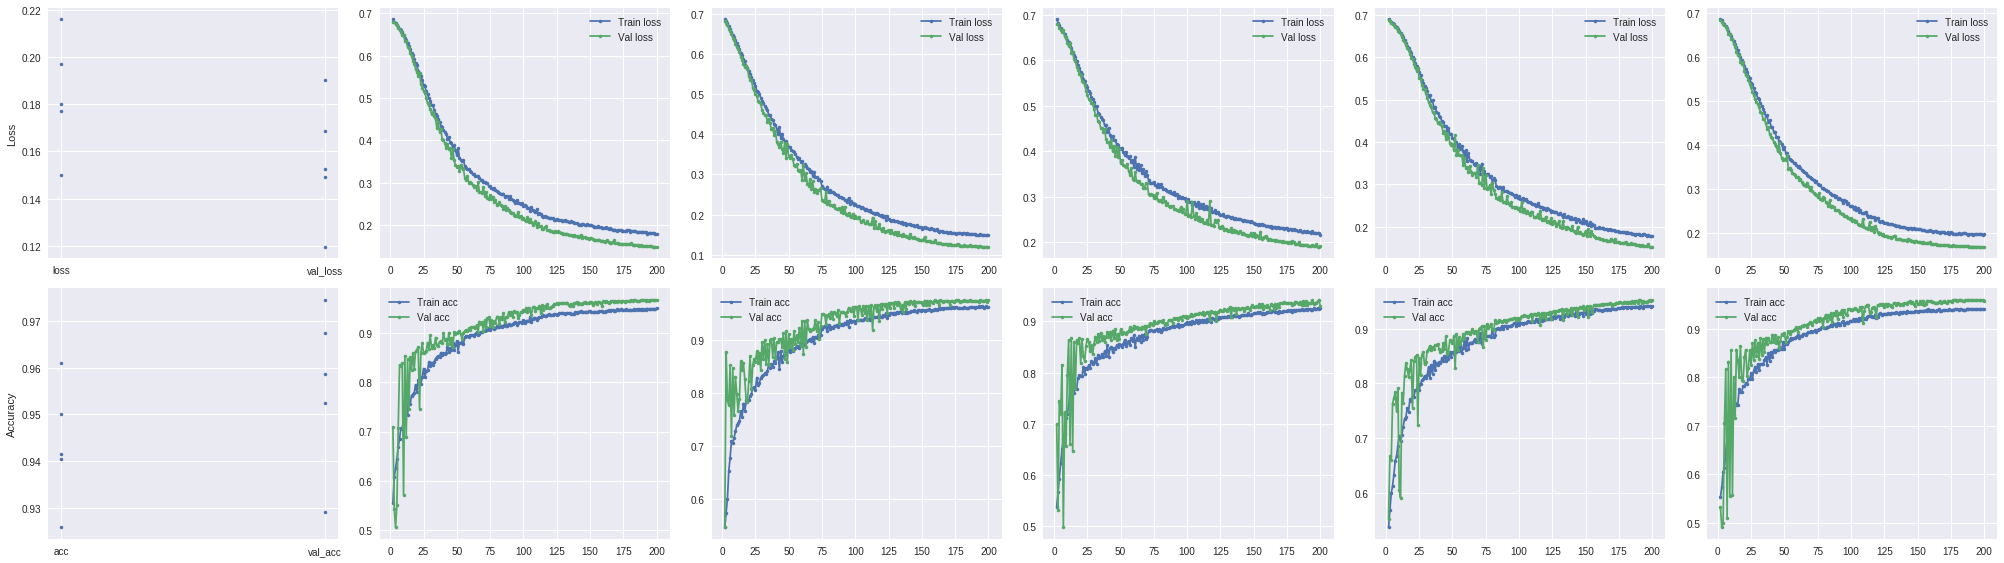

In [0]:
%%time

# 2 hidden layers, 2209 params, ~0.95 accu
callbacks = lambda: [
    ReduceLROnPlateau(patience=3, verbose=1, factor=0.5, min_lr=1e-5),
    EarlyStopping(patience=5, verbose=1)
]

_ = train(lambda x: Sequential([
    Dense(32, input_shape=(X.shape[1],), activation='relu'),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
]), callbacks=callbacks, verbose=1)

[save_keras_model(model, './model_NN_2_' + str(i)) for i, model in enumerate(models)];
!zip -r -qq models_NN_2.zip model_NN_2_0 model_NN_2_1 model_NN_2_2 model_NN_2_3 model_NN_2_4


## Convolution network

In [0]:
# convert the data to 2D

h = 135
w = 240
batch_size = 256 # can't use 512, memory crash in colab

def generate_img(features, targets):
    while 1:
        yield_features = []
        yield_targets = []
        reduced_features = np.round(features * w)
        reduced_features = np.int32(reduced_features).clip(0, w - 1)
        for feature, target in zip(reduced_features, targets):
            tmp = np.zeros((h, w, 1))
            for x, y in zip(feature[17:], feature[:17]): tmp[x, y] = [1]
            yield_features.append(tmp)
            yield_targets.append(target)
#             print('subprocess', subprocess.check_output(['free', '-h']).split()[7])
#             print('getsizeof', sys.getsizeof(tmp) // 1048576, 'length', len(yield_features))
            if (len(yield_features) == batch_size):
                yield np.array(yield_features), np.array(yield_targets)
                yield_features = []
                yield_targets = []


## Model_CNN_1

In [0]:
# this model has ~ 250k params, ~1.0 accu       
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(h, w, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
model.fit_generator(
    generate_img(X_train, y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=generate_img(X_val, y_val),
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

save_keras_model(model, './model_cnn_1')
!zip -rqq model_cnn_1.zip model_cnn_1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 133, 238, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 133, 238, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 133, 238, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 66, 119, 32)       0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 66, 119, 32)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 251328)            0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 251329    
Total para

## Model_CNN_2

In [0]:
# 6 Conv layer, ~ 62k params, ~1.0 accuracy

model = Sequential()
model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(135, 240, 1)))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()
model.fit_generator(
    generate_img(X_train, y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=10,
    validation_data=generate_img(X_val, y_val),
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

save_keras_model(model, './model_cnn_2')
!zip -rqq model_cnn_2.zip model_cnn_2

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 135, 240, 32)      320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 135, 240, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 67, 120, 32)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 67, 120, 32)       128       
_________________________________________________________________
dropout_8 (Dropout)          (None, 67, 120, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 67, 120, 32)       9248      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 67, 120, 32)       9248      
__________

## Convolution network with image augmentation

In [0]:
h = 135
w = 240

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.05,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
)

def generate_img(features, targets):
    while 1:
        yield_features = []
        yield_targets = []
        reduced_features = np.round(features * w)
        reduced_features = np.int32(reduced_features).clip(0, w - 1)
        for feature, target in zip(reduced_features, targets):
            tmp = np.zeros((h, w, 1)) # pic of 135 * 240 (H * W)
            for x, y in zip(feature[17:], feature[:17]): tmp[x, y] = [1]
            yield_features.append(tmp)
            yield_targets.append(target)
            if (len(yield_features) == batch_size):
#                 tmp = np.array(yield_features), np.array(yield_targets)
                yield next(datagen.flow(np.array(yield_features), np.array(yield_targets), batch_size=batch_size))
                yield_features = []
                yield_targets = []

## Model_CNN_3

In [0]:
# basic 1 Conv2D layer

# this model has ~ 250k params, bad val accu of 0.5, maybe due to image augmentation
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(h, w, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit_generator(
    generate_img(X_train, y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=25,
    validation_data=generate_img(X_val, y_val),
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

save_keras_model(model, './model_cnn_3')
!zip -rqq model_cnn_3.zip model_cnn_3


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 133, 238, 32)      320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 133, 238, 32)      128       
_________________________________________________________________
activation_5 (Activation)    (None, 133, 238, 32)      0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 66, 119, 32)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 66, 119, 32)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 251328)            0         
_________________________________________________________________
dense_72 (Dense)             (None, 1)                 251329    
Total para

## Model_CNN_4

In [0]:
# 3 Conv2D layers, 1.7M+ params, val acc 0.95

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(135, 240, 1)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()
model.fit_generator(
    generate_img(X_train, y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=25,
    validation_data=generate_img(X_val, y_val),
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

save_keras_model(model, './model_cnn_4')
!zip -rqq model_cnn_4.zip model_cnn_4


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 133, 238, 32)      320       
_________________________________________________________________
batch_normalization_12 (Batc (None, 133, 238, 32)      128       
_________________________________________________________________
activation_11 (Activation)   (None, 133, 238, 32)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 66, 119, 32)       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 117, 32)       9248      
_________________________________________________________________
batch_normalization_13 (Batc (None, 64, 117, 32)       128       
_________________________________________________________________
activation_12 (Activation)   (None, 64, 117, 32)       0         
__________

## Model_CNN_5

In [0]:
# adjust layers to lower the number of params, ~62k params, accuracy ~0.98

model = Sequential()
model.add(Conv2D(32, 3, padding='Same', activation='relu', input_shape=(135, 240, 1)))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(Conv2D(32, 3, padding='Same', activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])
model.summary()
model.fit_generator(
    generate_img(X_train, y_train),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=25,
    validation_data=generate_img(X_val, y_val),
    validation_steps=len(X_val) // batch_size,
    verbose=1
)

save_keras_model(model, './model_cnn_5')
!zip -rqq model_cnn_5.zip model_cnn_5

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 135, 240, 32)      320       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 135, 240, 32)      9248      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 67, 120, 32)       0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 67, 120, 32)       128       
_________________________________________________________________
dropout_17 (Dropout)         (None, 67, 120, 32)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 67, 120, 32)       9248      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 67, 120, 32)       9248      
__________

## Logistic regression with data augmentation

In [0]:
h = 135
w = 240

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.15,
    height_shift_range=0.05,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='constant',
)

def generate_img(features, targets):
    while 1:
        yield_features = []
        yield_targets = []
        reduced_features = np.round(features * w)
        reduced_features = np.int32(reduced_features).clip(0, w - 1)
        for feature, target in zip(reduced_features, targets):
            tmp = np.zeros((h, w, 1))
            for x, y in zip(feature[17:], feature[:17]): tmp[x, y] = [1]
            yield_features.append(tmp)
            yield_targets.append(target)
            if (len(yield_features) == batch_size):
                tmp = next(datagen.flow(np.array(yield_features), np.array(yield_targets), batch_size=batch_size))
                yield_features = []
                yield_targets = []
                result = np.zeros(34)
                yield tmp
                
tmp = next(generate_img(X_train, y_train))[0]


In [0]:
np.count_nonzero(tmp[0].reshape(h, w))

In [0]:
plt.imshow(tmp[1].reshape(h, w))